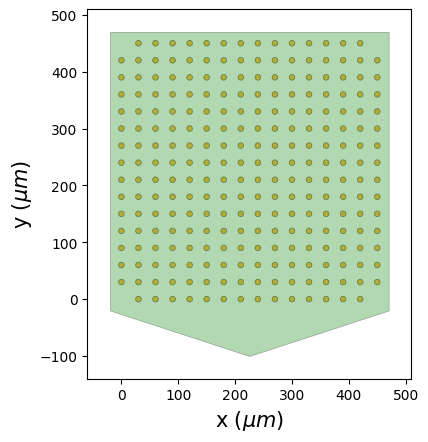

In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.auto import tqdm
import spikeinterface.full as si
import numpy as np
import os
import scipy

from utils import recording_onsets, is_holographic_rec, run_minimal_sanity_check, save_obj, load_obj

import probeinterface as pi
from probeinterface.plotting import plot_probe_group, plot_probe

# Load probe
probe = pi.read_prb('mcs_256_30_8iR_ITO.prb')

plot_probe_group(probe)
import matplotlib.pyplot as plt

def find_files(path):
    if os.path.isfile(os.path.normpath(path)):                                      #Check if given path is a file and if it exist
        with open(os.path.normpath(path)) as file:                                      #If yes, than open in variable "file"
            return file.read().splitlines()                                                 #return the text of each line as a file name ordered from top to bottom
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]       #If no, the path is considered as a folder and return the name of all the files in alphabetic order


def load_data(input_path, dtype='uint16', nb_channels=256, channel_id=127, probe_size=None, voltage_resolution=0.1042, disable=False):
    
    # Load data.
    m = np.memmap(os.path.normpath(input_path),dtype=dtype)
    
    #Input file sanity check
    if m.size % nb_channels != 0:
        message = "number of channels is inconsistent with the data size."
        raise Exception(message)
    
    
    nb_samples = m.size // nb_channels
    
    if probe_size:
        nb_samples = min(probe_size,nb_samples)
    
    data = np.empty((nb_samples,), dtype=dtype)
    for k in tqdm(range(nb_samples),disable = disable):
        data[k] = m[nb_channels * k + channel_id]
    data = data.astype(np.float64)
    data = data - np.iinfo('uint16').min + np.iinfo('int16').min
    data = data / voltage_resolution
    
    return data, nb_samples


def detect_onsets(data, threshold=170e+3):
    """
    Function to compute time point in the data coresponding to the display of a new frame of the stimuli based on trigger recording
    Input :
        - data (1D numpy array) : raw triggers data
        - threshold (int) : voltage value that detects onsets in data
        
    Output :
        - indices (1D numpy array) : list of time indices corresponding to the detected onsets time point
        
    Possible mistakes :
        - Threshold is no longer optimum and has to be changed
        - Wrong mea given as parameters
        - Data coming from the wrong channel
    """
    test_1 = data[:-1] < threshold
    test_2 = data[1:] >= threshold
    test = np.logical_and(test_1, test_2)
    
    indices = np.where(test)[0]
    
    test = data[indices - 1] < data[indices]
    while np.any(test):
        indices[test] = indices[test] - 1
        test = data[indices - 1] < data[indices]
    
    return indices

def detect_offsets(data,threshold=170e+3):
    
    test_1 = data[:-1] > threshold
    test_2 = data[1:] <= threshold
    test = np.logical_and(test_1, test_2)
    
    indices = np.where(test)[0]
    
    test = data[indices - 1] < data[indices]
    while np.any(test):
        indices[test] = indices[test] - 1
        test = data[indices - 1] < data[indices]
    
    return indices

# Open files

In [2]:
"""
    Input
"""

fs = 20000

root = "/media/guiglaz/VIP.Project_Single&Multicell/VIP.Project_VDH/20230828_VIP.Project_Synchro+MulltiSpot(dark)"

exp = "20230828_VIP.Project_Synchro+MulltiSpot(dark)"

raw_folder = os.path.join(root,"RAW_Files")

triggers_directory = os.path.join(root,"triggers")

frames_path = os.path.join(root,"20230828_VIP.Project_Synchro+Multispot_DHguiOptimization/frames")

saving_directory = os.path.join(root,'filtered')

recording_names = find_files(raw_folder)

recording_directory = raw_folder


"""
    Processing
"""

recording_names = [rec.replace('.raw','') for rec in recording_names]
rec_it = recording_names[:]+['end']
print('Number of recordings: {}\n'.format(len(recording_names)))

#getting onset for next prints
onsets = {}
onsets = recording_onsets(recording_names, path = recording_directory)

#Opening files
print('\nCheck that recordings lengths are consistent with recording names\n') 


for i in range(len(rec_it)-1):    
    print("{} minutes\t--->\t{} : {} -> OK".format(int((onsets[rec_it[i+1]]-onsets[rec_it[i]])/fs/60), i, rec_it[i]))


"""Output :

Var :
recordings_names : Ordered list of stimuli names played during experiment
"""   

print('\n\t\t\t------ End Of Cell ------')

FileNotFoundError: [Errno 2] No such file or directory: '/media/guiglaz/VIP.Project_Single&Multicell/VIP.Project_VDH/20230828_VIP.Project_Synchro+MulltiSpot(dark)/RAW_Files'

# Extract laser times

## With Trigger Channel

In [3]:
"""
    Inputs
"""
#you can decide here to extract the triggers only for some recordings. List their indexes here (starting from 0).
select_rec = [9]    # do only measurement N, put [] or the complet list to call all of them

#You can manually enter here the recording numbers for which you want to manually select the recording type. 
rec_type_manual_selection = [9] # will open an input box for all seleceted recordings listed in this varaible

"""
    Variable
    
    You will find here all variables used
    
    in this notebook cell. They should always refere to your 'params.py' file
    except if you want to manually change some variable only for this run (i.e. debugging). You may have to add those
    variable into the function you want to adapt as only the minimal amount of var are currently given to functions as inputs.
"""

# select MEA (3=2p room) (4=MEA1 Polycrhome)
MEA = 3                     

#the optimal threshhold for detecting stimuli onsets varies with the rig
threshold  = threshold  = 170e+3           

Nchannels  = 256                #256 for standard MEA, 17 for MEA1 Polychrome

# number of triggers samples acquired per second
fs         = 20000

# number of time points used to check if a recording is holographic or not
probe_size = 100000

#Channel recording triggers in case of holographic stimuli
holo_channel_id   = 127

#Channel recording triggers in case of visual stimuli
visual_channel_id = 126


"""
    Processing
"""

for rec in range(len(recording_names)):
    if select_rec:
        if rec not in select_rec: continue
    
    print('\n-------------   Processing recording {} out of {}   -------------\n'.format(rec+1,len(recording_names)))

    # Creating all files path
    input_file    = os.path.join(recording_directory,recording_names[rec]+'.raw')
    trigger_file  = os.path.join(triggers_directory,'{}_{}_triggers.pkl'.format(exp,recording_names[rec]))
    data_file     = os.path.join(triggers_directory,'{}_{}_triggers_data.pkl'.format(exp,recording_names[rec]))
    
    print('The triggers are extracted from the sorting file:\t{}\nand the results will be saved at:\t\t\t{}'.format(recording_names[rec]+'.raw',trigger_file))
    if os.path.exists(data_file):
        if (str(input('Trigers already extracted previously. Write again files files? Type Y to do so :\n')) != 'Y') : continue
    

    if rec in rec_type_manual_selection:
        print(f"Detected as holographic : {is_holo}")
        if(str(input("Is this an holographic recording ? If yes, type Y :")) == "Y"):
            is_holo = True
        else :
            is_holo = False
    else :
            is_holo = is_holographic_rec(input_file)
    
    
    if is_holo: 
        #in this case the stimulus was holograpic
        print(r" /!\ HOLOGRAPHIC Recording /!\ ")
        channel_id   = holo_channel_id
        trigger_type = 'holo'
        onsets_file  = os.path.join(triggers_directory,'{}_{}_laser_onsets.npy'.format(exp,recording_names[rec]))
        offsets_file  = os.path.join(triggers_directory,'{}_{}_laser_offsets.npy'.format(exp,recording_names[rec]))
    else: 
        #in this other case the stimulus was visual
        print(r" /!\ VISUAL Recording /!\ ")
        channel_id   = visual_channel_id        
        trigger_type = 'visual'
    
    #Processing of data calling utils functions
    print("Loading Data...")    
    
    data, t_tot    = load_data(input_file, channel_id = channel_id )
    
    indices        = detect_onsets(data,threshold)
    indices_errors = run_minimal_sanity_check(indices, stim_type = trigger_type)
    
    #Saving data using utils function save_obj
    save_obj({'indices':indices,'duration':t_tot,'trigger_type':trigger_type,'indice_errors':indices_errors}, trigger_file )
    save_obj(data,data_file)
    

    if trigger_type == 'holo':
        save_obj(indices, onsets_file)
    
        offsets = detect_offsets(data)
        save_obj(offsets, offsets_file)    
        
"""
    Output
    
    Saved in triggers_directory :

{experience_name}_{link_file_name}_triggers.pkl (dict) : 
    keys 'indices' --> detected triggers indices, 
         'duration' --> the stimuli duration, 
         'trigger_type' --> the detection visual or holo stimuli, 
         'indice_errors' --> triggers violating sanity check 
         
{experience_name}_{link_file_name}_triggers_data.pkl (numpy array) : raw signal recorded on the trigger channel

"""
print('\n\t\t\t------ End Of Cell ------')


-------------   Processing recording 10 out of 21   -------------

The triggers are extracted from the sorting file:	09_HoloStim1_LAP4+ACET_N8_Z(-40).raw
and the results will be saved at:			/media/guiglaz/VIP.Project_Single&Multicell/VIP.Project_VDH/20230828_VIP.Project_Synchro+MulltiSpot(dark)/triggers/20230828_VIP.Project_Synchro+MulltiSpot(dark)_09_HoloStim1_LAP4+ACET_N8_Z(-40)_triggers.pkl
Trigers already extracted previously. Write again files files? Type Y to do so :


			------ End Of Cell ------


## With Axorus Pain

# Process Recordings

In [5]:
artefact_removal_method = 'zeros'
recordings = {}
for recording_name in recording_names:
    recordings[recording_name] = {}
    
    extracted = load_obj(os.path.normpath(os.path.join(triggers_directory,'{}_{}_triggers.pkl'.format(exp,recording_name))))
    trigger_type = extracted['trigger_type']
    
    # Open file
    recordings[recording_name]['raw'] = si.read_binary(os.path.join(recording_directory,recording_name+'.raw'), sampling_frequency=fs, num_chan=Nchannels, dtype='uint16')
    print(f"{recording_name} \n Opened", end=' ')
    print(recordings[recording_name]['raw'])
    # Filter recordings
    recordings[recording_name]['si_filtered'] = si.bandpass_filter(recordings[recording_name]['raw'], dtype="uint16")
    print("--> Filtered bandpass",end=' ')
    print(recordings[recording_name]['si_filtered'])
    # Remove median for all recordings
    recordings[recording_name]['si_filtered_medianremoved'] = si.common_reference(recordings[recording_name]['si_filtered'])
    print("--> Median removed", end=' ')
    print(recordings[recording_name]['si_filtered_medianremoved'])
    
    if trigger_type == 'holo':       
        #Onsets and offsets loading
        stim_onsets = load_obj(os.path.join(triggers_directory,'{}_{}_laser_onsets.npy'.format(exp,recording_name)))
        stim_offsets = load_obj(os.path.join(triggers_directory,'{}_{}_laser_offsets.npy'.format(exp,recording_name)))

        #Computing times of laser bims
        times = np.sort(np.concatenate((stim_onsets, stim_offsets)))

        #Removing artefacts
        recordings[recording_name]['si_cleaned_zeros'] = si.remove_artifacts(recordings[recording_name]['si_filtered_medianremoved'], 
                                                               list_triggers=[list(times)], 
                                                               ms_before=5, 
                                                               ms_after=5, 
                                                               mode=artefact_removal_method)
        print("--> laser on and off times set to 0") 
    print('\n')


print('\n\t\t\t------ End Of Cell ------')

07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz 
 Opened BinaryRecordingExtractor: 256 channels - 1 segments - 20.0kHz - 276.200s
  file_paths: ['/media/guiglaz/VIP.Project_Single&Multicell/VIP.Project_VDH/20230828_VIP.Project_Synchro+MulltiSpot(dark)/RAW_Files/07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz.raw']
--> Filtered bandpass BandpassFilterRecording: 256 channels - 1 segments - 20.0kHz - 276.200s
--> Median removed CommonReferenceRecording: 256 channels - 1 segments - 20.0kHz - 276.200s


00_Checkerboard_30ND50%_20pix30checks_30Hz 
 Opened BinaryRecordingExtractor: 256 channels - 1 segments - 20.0kHz - 1330.800s
  file_paths: ['/media/guiglaz/VIP.Project_Single&Multicell/VIP.Project_VDH/20230828_VIP.Project_Synchro+MulltiSpot(dark)/RAW_Files/00_Checkerboard_30ND50%_20pix30checks_30Hz.raw']
--> Filtered bandpass BandpassFilterRecording: 256 channels - 1 segments - 20.0kHz - 1330.800s
--> Median removed CommonReferenceRecording: 256 channels - 1 segments - 20.0kHz - 1330.800s


01_Checkerboard_30N

In [ ]:
#Manually adding times to remove with 10ms 0 window
times = []

artefact_removal_method = 'zeros'

print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recordings.keys())], sep="\n")
recording_name = recording_names[int(input("\nSelected recording: "))]

recordings[recording_name]['manually_removed_tirggers'] = si.remove_artifacts(recordings[recording_name]['si_cleaned_zeros'], 
                                                               list_triggers=[times], 
                                                               ms_before=5, 
                                                               ms_after=5, 
                                                               mode=artefact_removal_method)

# Visualize artefact

0 : 07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz
1 : 00_Checkerboard_30ND50%_20pix30checks_30Hz
2 : 01_Checkerboard_30ND50%_16pix40checks_30Hz
3 : 02_DG_30ND50%_2sT_50Hz
4 : 03_Chirp_20reps_30ND50%_50Hz
5 : 04_Flicker_BeforeDrugs_30ND50%_1Hz
6 : 05_VDH_Synchro+MultiSpots(dark)_N8_Z(-40)_30ND50%_40Hz
7 : 06_VDH_Synchro_N10_Z(-40)_30ND50%_40Hz
8 : 08_Flicker_LAP4+ACET_t+30_30ND50%_1Hz
9 : 09_HoloStim1_LAP4+ACET_N8_Z(-40)
10 : 10_HoloStim1_LAP4+ACET_N30_Z(-40)
11 : 11_OptoStim1_30ND50%_1Hz
12 : 12_OptoStim1_LAP4+ACET_15ND50%_1Hz
13 : 13_OptoStim1_LAP4+ACET_5ND50%_1Hz
14 : 14_HoloStim2_SR95531_t30_N30_Z(-40)
15 : 15_OptoStim2_SR95531_30ND50%_1Hz
16 : 16_OptoStim2_SR95531_15ND50%_1Hz
17 : 17_OptoStim2_SR95531_5ND50%_1Hz
18 : 18_HoloStim3_18BG_t5_N30_Z(-40)
19 : 19_OptoStim3_18BG_15ND50%_1Hz
20 : 20_OptoStim3_18BG_5ND50%_1Hz

Select holographic recording : 9
0 : DH_frames.mat
1 : DH_frames_20230828_15_00_49.mat
2 : DH_frames_20230828_17_12_03.mat
3 : DH_frames_20230828_18_05_54.mat
4 : DH_frames_20

extract waveforms shared_memory:   0%|          | 0/183 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory:   0%|          | 0/183 [00:00<?, ?it/s]

extract waveforms shared_memory:   0%|          | 0/183 [00:00<?, ?it/s]

Setting 'return_scaled' to False


extract waveforms shared_memory:   0%|          | 0/183 [00:00<?, ?it/s]

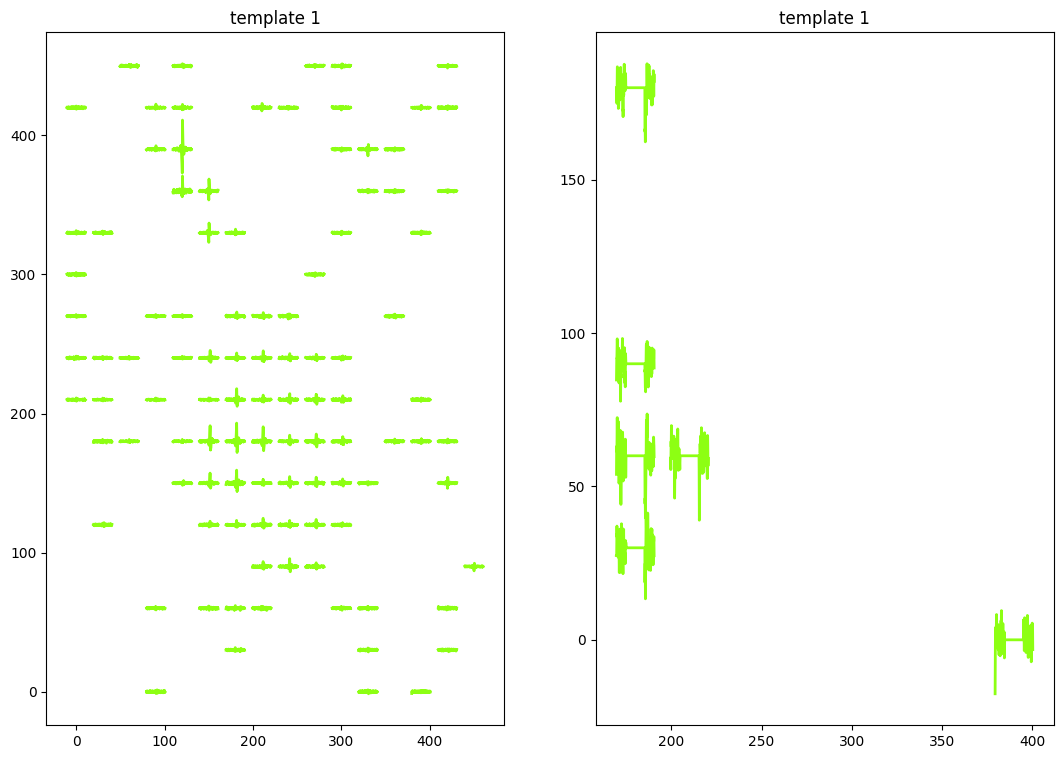

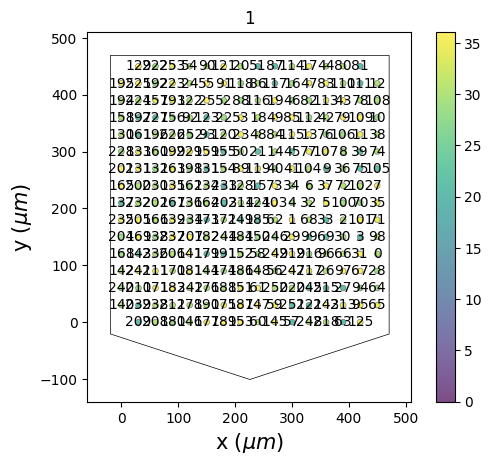

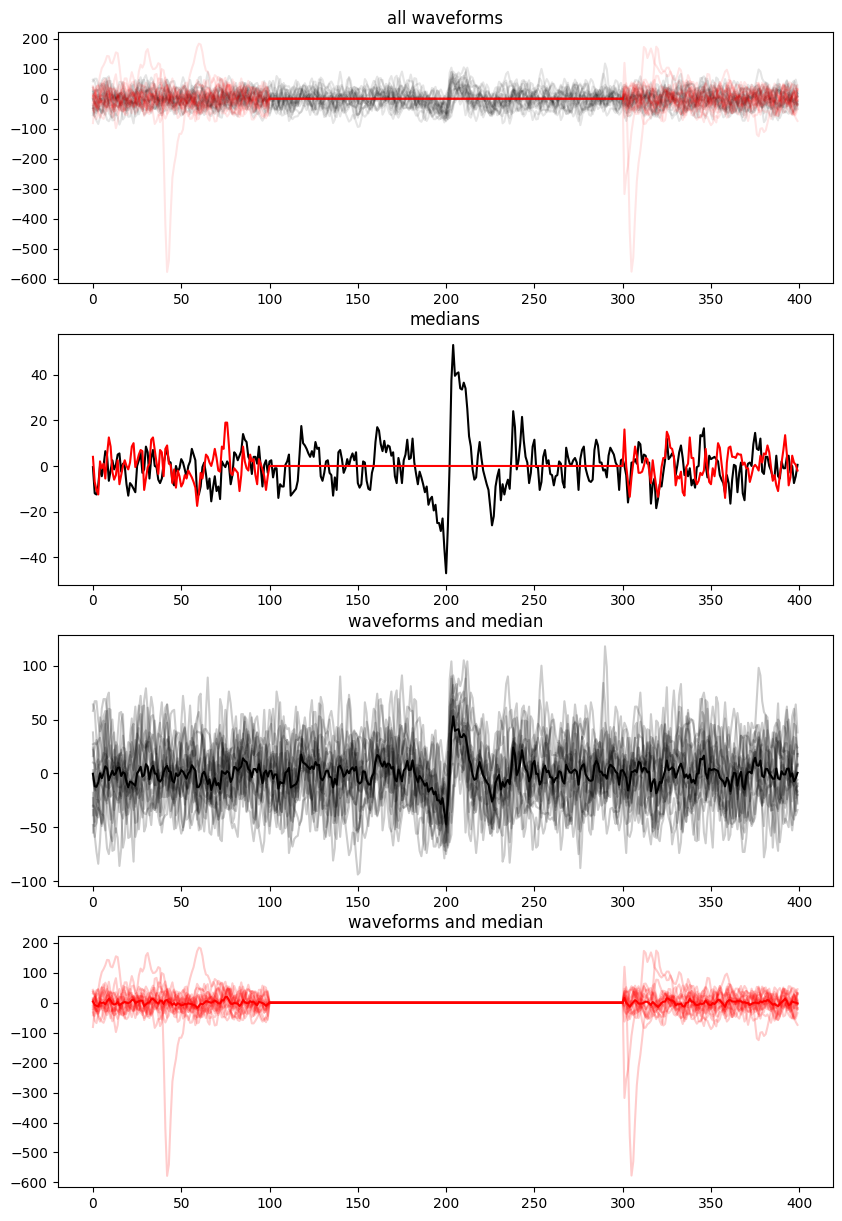


			------ End Of Cell ------


In [17]:
#import pylab as plt

waveform_id = 1 #waveform patern number
elec = 1  #electrode number

print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recordings.keys())], sep="\n")
recording_name = recording_names[int(input("\nSelect holographic recording : "))]


frames_folder_files = [f for f in os.listdir(frames_path) if os.path.isfile(os.path.join(frames_path, f))]
print(*['{} : {}'.format(i,frame_file) for i, frame_file in enumerate(frames_folder_files)], sep="\n")
frame_name = frames_folder_files[int(input(f"\nSelect the DH_frames file for the recording {recording_name} \n"))]

#Frames loading
frames = scipy.io.loadmat(os.path.join(frames_path, frame_name))
spot_order = np.array([i[0] for i in frames['OrderFrames']])

#Onsets and offsets loading
onsets_file  = os.path.join(triggers_directory,'{}_{}_laser_onsets.npy'.format(exp,recording_name))
offsets_file  = os.path.join(triggers_directory,'{}_{}_laser_offsets.npy'.format(exp,recording_name))

stim_onsets = load_obj(onsets_file)
stim_offsets = load_obj(offsets_file)

#Computing times of laser bims
times = np.concatenate((stim_onsets, stim_offsets))
labels = np.concatenate((spot_order, spot_order+max(spot_order)))
idx = np.argsort(times)
times = times[idx]
labels = labels[idx]

sorting = si.NumpySorting.from_times_labels(times, labels, sampling_frequency=fs)
sorting = sorting.save()


waveforms = {}
waveforms['si_filtered_medianremoved'] = si.extract_waveforms(recordings[recording_name]['si_filtered_medianremoved'].set_probegroup(probe), 
                             sorting, ms_before=10, ms_after=10, mode='memory',
     n_jobs=10, allow_unfiltered=True, chunk_memory="10M", overwrite=True, sparse=True, method='snr', threshold=1)

waveforms['si_cleaned_zeros'] = si.extract_waveforms(recordings[recording_name]['si_cleaned_zeros'].set_probegroup(probe), 
                             sorting, ms_before=10, ms_after=10, mode='memory',
     n_jobs=10, allow_unfiltered=True, chunk_memory="10M", overwrite=True, sparse=True, method='snr', threshold=1,)


## Plotting waveform with the probe plot

fig, axes = plt.subplots(1,2, figsize=(13,9))
si.plot_unit_templates(waveforms['si_filtered_medianremoved'], 
                       unit_ids=[waveform_id], same_axis=True, ax=axes[0], plot_legend=False)
si.plot_unit_templates(waveforms['si_cleaned_zeros'], 
                       unit_ids=[waveform_id], same_axis=True, ax=axes[1], plot_legend=False)

si.plot_unit_probe_map(waveforms['si_cleaned_zeros'], unit_ids=[waveform_id], with_channel_ids=True)


## Plotting waveform electrode wise  

unit_id = waveform_id

colors = ['k', 'r', 'b']

fig, axs = plt.subplots(4,1, figsize=(10,15))

ax = axs[0]
for i_key, key in enumerate(['si_filtered_medianremoved', 'si_cleaned_zeros']):
    wfs= waveforms[key].get_waveforms(unit_id=unit_id)
    for i_wf in range(wfs.shape[0]):
        ax.plot(wfs[i_wf,:,elec], color = colors[i_key],
                 label=key,
                alpha=0.1)
    ax.set_title("all waveforms")
        
ax = axs[1]
for i_key, key in enumerate(['si_filtered_medianremoved', 'si_cleaned_zeros']):
    wfs= waveforms[key].get_waveforms(unit_id=unit_id)
    ax.plot(np.median(wfs[:,:,elec],axis=0),
           color = colors[i_key])
    ax.set_title("medians")
        
for i_key, key in enumerate(['si_filtered_medianremoved', 'si_cleaned_zeros',]):
    ax = axs[i_key+2]

    wfs= waveforms[key].get_waveforms(unit_id=unit_id)
    for i_wf in range(wfs.shape[0]):
        ax.plot(wfs[i_wf,:,elec], color = colors[i_key],
                 label=key,
                alpha=0.2)
    ax.plot(np.median(wfs[:,:,elec],axis=0),
           color = colors[i_key])

    ax.set_title("waveforms and median")

plt.show(block=False)
print('\n\t\t\t------ End Of Cell ------')

# Visualize recording

0 : 07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz
1 : 00_Checkerboard_30ND50%_20pix30checks_30Hz
2 : 01_Checkerboard_30ND50%_16pix40checks_30Hz
3 : 02_DG_30ND50%_2sT_50Hz
4 : 03_Chirp_20reps_30ND50%_50Hz
5 : 04_Flicker_BeforeDrugs_30ND50%_1Hz
6 : 05_VDH_Synchro+MultiSpots(dark)_N8_Z(-40)_30ND50%_40Hz
7 : 06_VDH_Synchro_N10_Z(-40)_30ND50%_40Hz
8 : 08_Flicker_LAP4+ACET_t+30_30ND50%_1Hz
9 : 09_HoloStim1_LAP4+ACET_N8_Z(-40)
10 : 10_HoloStim1_LAP4+ACET_N30_Z(-40)
11 : 11_OptoStim1_30ND50%_1Hz
12 : 12_OptoStim1_LAP4+ACET_15ND50%_1Hz
13 : 13_OptoStim1_LAP4+ACET_5ND50%_1Hz
14 : 14_HoloStim2_SR95531_t30_N30_Z(-40)
15 : 15_OptoStim2_SR95531_30ND50%_1Hz
16 : 16_OptoStim2_SR95531_15ND50%_1Hz
17 : 17_OptoStim2_SR95531_5ND50%_1Hz
18 : 18_HoloStim3_18BG_t5_N30_Z(-40)
19 : 19_OptoStim3_18BG_15ND50%_1Hz
20 : 20_OptoStim3_18BG_5ND50%_1Hz

Select holographic recording : 18


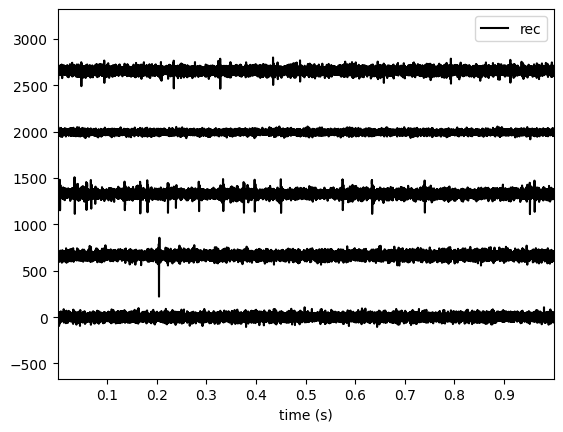

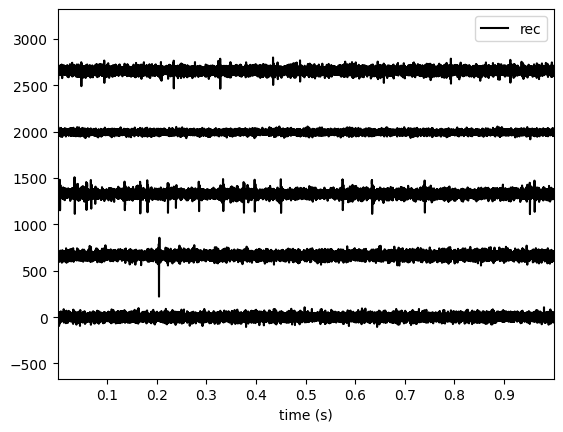

In [33]:
#Time range is the set of the first and lats second to plot
time_range = (0, 1)
ch_id = [10,52,112,198,236]

print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(recordings.keys())], sep="\n")
recording_name = recording_names[int(input("\nSelect holographic recording : "))]

try:
    si.plot_timeseries(recordings[recording_name]['si_cleaned_zeros'], time_range=time_range, channel_ids=ch_id)
except :
    pass

si.plot_timeseries(recordings[recording_name]['si_filtered_medianremoved'], time_range=time_range, channel_ids=ch_id)
plt.show(block='False')

# Export New Raw

### Caution !! New written files are on int16 and not unit16 !!! Change this in your circus param file

In [8]:
if not os.path.exists(saving_directory): os.makedirs(saving_directory)

print(f"Saving filtered files in folder : {saving_directory}\n")
    
selected_files = []      #Choose here to write only specific recordings (index in the recording names list). If empty list, all recordings are being written
    
for rec_idx, recording_name in enumerate(recordings.keys()):
    
    if selected_files :
        if rec_idx not in selected_files : 
            continue
            
    
    if 'manually_removed_tirggers' in recordings[recording_name].keys():
        saving_name = recording_name + r'_Manually_Filtered_Cleaned_Zeros.raw'
        recording_to_save = recordings[recording_name]['manually_removed_tirggers']
    
    elif "si_cleaned_zeros" in recordings[recording_name].keys():      
        saving_name = recording_name + r'_Filtered_Cleaned_Zeros.raw'
        recording_to_save = recordings[recording_name]['si_cleaned_zeros']
        
    else:
        saving_name = recording_name + r'_Filtered.raw'
        recording_to_save = recordings[recording_name]['si_filtered_medianremoved']
        
    print(f"{saving_name} :")
    si.write_binary_recording(recording_to_save, file_paths=os.path.join(saving_directory,saving_name), dtype='int16', add_file_extension=True, 
                          verbose=True, byte_offset=0, auto_cast_uint=False, n_jobs=10, progress_bar=True)
    
print("\nEND")

Saving filtered files in folder : /media/guiglaz/VIP.Project_Single&Multicell/VIP.Project_VDH/20230828_VIP.Project_Synchro+MulltiSpot(dark)/filtered

07_Flicker_LAP4+ACET_t+10_30ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/277 [00:00<?, ?it/s]

00_Checkerboard_30ND50%_20pix30checks_30Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/1331 [00:00<?, ?it/s]

01_Checkerboard_30ND50%_16pix40checks_30Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/2852 [00:00<?, ?it/s]

02_DG_30ND50%_2sT_50Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/409 [00:00<?, ?it/s]

03_Chirp_20reps_30ND50%_50Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/667 [00:00<?, ?it/s]

04_Flicker_BeforeDrugs_30ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/265 [00:00<?, ?it/s]

05_VDH_Synchro+MultiSpots(dark)_N8_Z(-40)_30ND50%_40Hz_Filtered_Cleaned_Zeros.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/7300 [00:00<?, ?it/s]

06_VDH_Synchro_N10_Z(-40)_30ND50%_40Hz_Filtered_Cleaned_Zeros.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/1030 [00:00<?, ?it/s]

08_Flicker_LAP4+ACET_t+30_30ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/272 [00:00<?, ?it/s]

09_HoloStim1_LAP4+ACET_N8_Z(-40)_Filtered_Cleaned_Zeros.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/181 [00:00<?, ?it/s]

10_HoloStim1_LAP4+ACET_N30_Z(-40)_Filtered_Cleaned_Zeros.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/627 [00:00<?, ?it/s]

11_OptoStim1_30ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/377 [00:00<?, ?it/s]

12_OptoStim1_LAP4+ACET_15ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]

13_OptoStim1_LAP4+ACET_5ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/231 [00:00<?, ?it/s]

14_HoloStim2_SR95531_t30_N30_Z(-40)_Filtered_Cleaned_Zeros.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/619 [00:00<?, ?it/s]

15_OptoStim2_SR95531_30ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/294 [00:00<?, ?it/s]

16_OptoStim2_SR95531_15ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/396 [00:00<?, ?it/s]

17_OptoStim2_SR95531_5ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/273 [00:00<?, ?it/s]

18_HoloStim3_18BG_t5_N30_Z(-40)_Filtered_Cleaned_Zeros.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/641 [00:00<?, ?it/s]

19_OptoStim3_18BG_15ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/326 [00:00<?, ?it/s]

20_OptoStim3_18BG_5ND50%_1Hz_Filtered.raw :
write_binary_recording with n_jobs = 10 and chunk_size = 20000


write_binary_recording:   0%|          | 0/356 [00:00<?, ?it/s]


END


In [ ]:
#Time range is the set of the first and lats second to plot
time_range=(39, 40)
ch_id = [10,52,112,198,236]

written_files = find_files(saving_directory)

print(*['{} : {}'.format(i,recording_name) for i, recording_name in enumerate(written_files)], sep="\n")
recording_name = written_files[int(input("\nSelect recording : "))]
print(recording_name)
recording = si.read_binary(os.path.join(saving_directory,recording_name), sampling_frequency=fs, num_chan=Nchannels, dtype='int16')



si.plot_timeseries(recording, time_range=time_range, channel_ids=ch_id)
plt.title(recording_name)
plt.show(block='False')